## Imports

In [48]:
!pip install fastFM
!pip install surprise 
!pip install lightfm
!pip install hyperopt

In [4]:
import pandas as pd
import math
import numpy as np
import random
from numpy.linalg import inv
from numpy.linalg import multi_dot
import matplotlib.pyplot as plt
import itertools
import warnings
from math import sqrt
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from fastFM import als
from sklearn.metrics import mean_squared_error
from lightfm.datasets import fetch_movielens
from lightfm import LightFM
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
warnings.filterwarnings("ignore")
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity

##Get sampled data from location in drive

In [6]:
def get_data():
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  # Authenticate and create the PyDrive client.
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  id = "1FFYnZRIuzQLeBkDUuJpK_oRtUmdxMd9O"

  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile('final_dataset.csv')  
  data = pd.read_csv('final_dataset.csv')
  return data


In [7]:
data = get_data()

## Create train-test datasets

In [8]:
def train_test_split(data):

  user_freq=data.groupby(['userId']).size().reset_index(name='counts')
  users_lt3=user_freq[user_freq['counts']<3][['userId']]
  users_ge3=user_freq[user_freq['counts']>=3][['userId']]
  train1=pd.merge(data, users_lt3, on=['userId'],how='inner')
  data1=pd.merge(data, users_ge3, on=['userId'],how='inner')
  data1.sort_values(['userId', 'timestamp'], ascending=[True, False],inplace=True)
  test=data1.groupby('userId').sample(frac=.3, random_state=2) 
  test_idx=data1.index.isin(test.index.to_list())
  train=train1.append(data1[~test_idx])
  return train, test, user_freq

train, test, user_freq = train_test_split(data)

### Create data for giving inputs to model

In [9]:
def create_interaction_matrix(df,user_col, item_col, rating_col):

    interactions = df.groupby([user_col, item_col])[rating_col] \
            .sum().unstack().reset_index(). \
            fillna(0).set_index(user_col)

    return interactions

In [10]:
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0 
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict

In [11]:
def create_item_dict(df,id_col,name_col):
    item_dict ={}
    for i in range(df.shape[0]):
        item_dict[(df.loc[i,id_col])] = df.loc[i,name_col]
    return item_dict

In [14]:
def create_data_fm(train, test, user_freq):
  train=train[['userId', 'movieId', 'rating']]
  test=test[['userId', 'movieId', 'rating']]

  train.rename(columns = {'rating':'0_rating'}, inplace = True) 
  test.rename(columns = {'rating':'0_rating'}, inplace = True) 
  missing_test_users = user_freq[user_freq['counts']<3]['userId'].values
  interactions = create_interaction_matrix(df = train,
                                          user_col = 'userId',
                                          item_col = 'movieId',
                                          rating_col = '0_rating')
  test_int=create_interaction_matrix(df = test,
                                          user_col = 'userId',
                                          item_col = 'movieId',
                                          rating_col = '0_rating')
  a = np.zeros(shape=(len(missing_test_users),test_int.shape[1]))
  missing = pd.DataFrame(a,columns= test_int.columns.values)
  missing = missing.set_index(missing_test_users)
  test_int = pd.concat([test_int,missing])
  return interactions, test_int

interactions, test_int = create_data_fm(train,test, user_freq)

## Bayesian hyperparameter tuning

In [15]:
from lightfm.evaluation import precision_at_k
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK,space_eval

def fm_fn(params): 

  x = sparse.csr_matrix(interactions.values)
  test_intr = sparse.csr_matrix(test_int.values)

  fm = LightFM(loss='warp',no_components = params['n_components'],k=params['k'])

  fm.fit(x,epochs = params['epoch'],num_threads=3)

  # results = cross_validate(model, train, measures = ['rmse'],cv=5, verbose=True)
  
  res = precision_at_k(fm,test_interactions = test_intr, k=params['k']).mean()
  return -res

In [16]:
space = {
        'n_components': hp.choice('n_components',[10,15,20,30]),
        'epoch': hp.choice('epoch', [50,30,100]),
         'k': hp.choice('k', [20,10,30])
    }
trials = Trials()

best = fmin(algo = tpe.suggest,
               fn = fm_fn,
               trials = trials,
               max_evals = 20,
               space = space)

100%|██████████| 20/20 [18:24<00:00, 55.22s/it, best loss: -0.06386011838912964]


In [22]:
space_eval(space, best)

{'epoch': 30, 'k': 10, 'n_components': 15}

In [31]:
n_comps = [10,15,20,30]
epochs = [50,30,100]
k = [20,10,30]

In [45]:
n_comps[trials.trials[0]['misc']['vals']['n_components'][0]]

15

In [40]:
[epochs[x['misc']['vals']['epoch'][0]] for x in trials.trials]

[50,
 100,
 100,
 100,
 30,
 50,
 100,
 30,
 50,
 50,
 30,
 30,
 100,
 100,
 100,
 50,
 30,
 100,
 50,
 100]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f441289f630>,
      dtype=object)

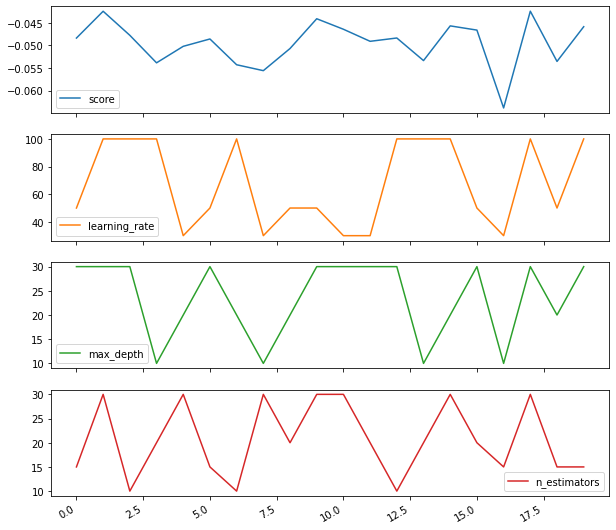

In [47]:
tpe_results=np.array([[x['result']['loss'],epochs[x['misc']['vals']['epoch'][0]], k[x['misc']['vals']['k'][0]],
                      n_comps[x['misc']['vals']['n_components'][0]] ]
                      for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
tpe_results_df.plot(subplots=True,figsize=(10, 10))

We find the best parameters are 'epoch': 30, 'k': 10, 'n_components': 15

OPTIMIZED MODEL

In [ ]:
def runFM(interactions, n_components,  k, epoch ,loss='warp', n_jobs = 4):

    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components= n_components, loss=loss,k=k)
    model.fit(x,epochs=epoch,num_threads = n_jobs)
    return model

In [ ]:
def train_fm_model(train, test, user_freq):
  interactions, test_int = create_data(train,test, user_freq)
  mf_model = runFM(interactions,10,10,30)
  return mf_model

mf_model = train_fm_model(train, test, user_freq)

In [ ]:
def get_fm_predictions(fm_model):
  user_dict = create_user_dict(interactions=interactions)
  movies_dict = create_item_dict(df = movies,
                               id_col = 'movieId',
                               name_col = 'title')
  u_list=list(user_dict.values())
  n_users, n_items = interactions.shape


  preds=pd.DataFrame(columns=['userId','movieId','prediction'])

  def predictions(users):
    u_vec=[users]*n_items
    i_vec=list(np.arange(n_items))
    r_vec=list(mf_model.predict(users,np.arange(n_items)))
    data = pd.DataFrame({'userId': u_vec, 'movieId': i_vec,'prediction':r_vec})
    return(data)
  
  epc = list(map(predictions,u_list))
  df = pd.concat(epc)
  m_ls=list(interactions.columns)
  m_id=list(np.arange(len(m_ls)))
  movie_df = pd.DataFrame({'m_id': m_ls, 'movieId': m_id})

  u_ls=list(interactions.index)
  u_id=list(np.arange(len(u_ls)))
  user_df = pd.DataFrame({'u_id': u_ls, 'userId': u_id})

  df=pd.merge(pd.merge(df,user_df,on=['userId'],how='inner'),movie_df,on=['movieId'],how='inner')
  df.drop(['movieId','userId'],axis=1,inplace=True)
  df.rename({'u_id': 'userId', 'm_id': 'movieId'}, axis=1, inplace=True)
  
  merged = pd.merge(train, df, on=["userId", "movieId"], how="outer")
  all_predictions = merged[merged['0_rating'].isnull()].drop('0_rating', axis=1)

  all_predictions = all_predictions.rename(columns={'prediction':'predictions'})

  return all_predictions 

fm_predictions = get_fm_predictions(mf_model)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all_predictions.to_csv('/content/drive/MyDrive/main_data/fm_jay_warp.csv',index = None)

In [ ]:
train['userId'].nunique()

20974